In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from math import floor
from termcolor import colored as cl

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

In [2]:
def get_historical_data(symbol, start_date):
    api_key = 'bf9c188e2a594111bc4144239c8a359d'
    api_url = f'https://api.twelvedata.com/time_series?symbol={symbol}&interval=1day&outputsize=5000&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['values']).iloc[::-1].set_index('datetime').astype(float)
    df = df[df.index >= start_date]
    df.index = pd.to_datetime(df.index)
    return df

tsla = get_historical_data('TSLA', '2020-01-01')
tsla

,open,high,low,close,volume
datetime,,,,,
2020-01-02,28.30000,28.71,28.11000,28.68000,143375936.0
2020-01-03,29.37000,30.27,29.13000,29.53000,266920720.0
2020-01-06,29.36000,30.10,29.33000,30.10000,152362640.0
2020-01-07,30.76000,31.44,30.22000,31.27000,273137344.0
2020-01-08,31.58000,33.23,31.22000,32.81000,467991360.0
...,...,...,...,...,...
2023-03-21,188.28000,198.00,188.03999,197.58000,153391400.0
2023-03-22,199.30000,200.66,190.95000,191.14999,150376400.0
2023-03-23,195.25999,199.31,188.64999,192.22000,144193900.0


In [4]:
def get_aroon(symbol, lookback, start_date):
    api_key = 'bf9c188e2a594111bc4144239c8a359d'
    api_url = f'https://api.twelvedata.com/aroon?symbol={symbol}&interval=1day&time_period={lookback}&outputsize=5000&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['values']).iloc[::-1].set_index('datetime').astype(float)
    df = df[df.index >= start_date]
    df.index = pd.to_datetime(df.index)
    aroon_up = df['aroon_up']
    aroon_down = df['aroon_down']
    return aroon_up, aroon_down

tsla['aroon_up'], tsla['aroon_down'] = get_aroon('TSLA', 25, '2020-01-01')
tsla.tail()

,open,high,low,close,volume,aroon_up,aroon_down
datetime,,,,,,,
2023-03-21,188.28000,198.00,188.03999,197.58000,153391400.0,12.0,76.0
2023-03-22,199.30000,200.66,190.95000,191.14999,150376400.0,8.0,72.0
2023-03-23,195.25999,199.31,188.64999,192.22000,144193900.0,4.0,68.0
2023-03-24,191.64999,192.36,187.14999,190.41000,116312400.0,0.0,64.0
2023-03-27,194.62000,197.39,189.94000,192.62000,115886710.0,24.0,60.0


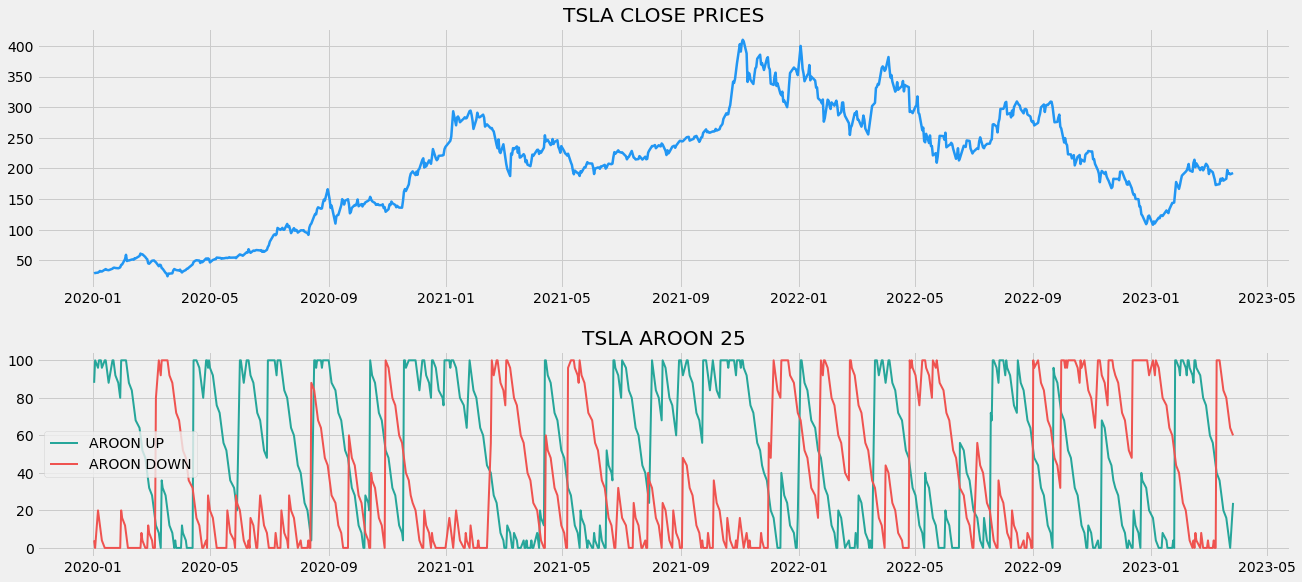

In [5]:
ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 4, colspan = 1)
ax1.plot(tsla['close'], linewidth = 2.5, color = '#2196f3')
ax1.set_title('TSLA CLOSE PRICES')
ax2.plot(tsla['aroon_up'], color = '#26a69a', linewidth = 2, label = 'AROON UP')
ax2.plot(tsla['aroon_down'], color = '#ef5350', linewidth = 2, label = 'AROON DOWN')
ax2.legend()
ax2.set_title('TSLA AROON 25')
plt.show()

In [6]:
def implement_aroon_strategy(prices, up, down):
    buy_price = []
    sell_price = []
    aroon_signal = []
    signal = 0
    
    for i in range(len(prices)):
        if up[i] >= 70 and down[i] <= 30:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                aroon_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                aroon_signal.append(0)
        elif up[i] <= 30 and down[i] >= 70:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                aroon_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                aroon_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            aroon_signal.append(0)
            
    return buy_price, sell_price, aroon_signal

buy_price, sell_price, aroon_signal = implement_aroon_strategy(tsla['close'], tsla['aroon_up'], tsla['aroon_down'])

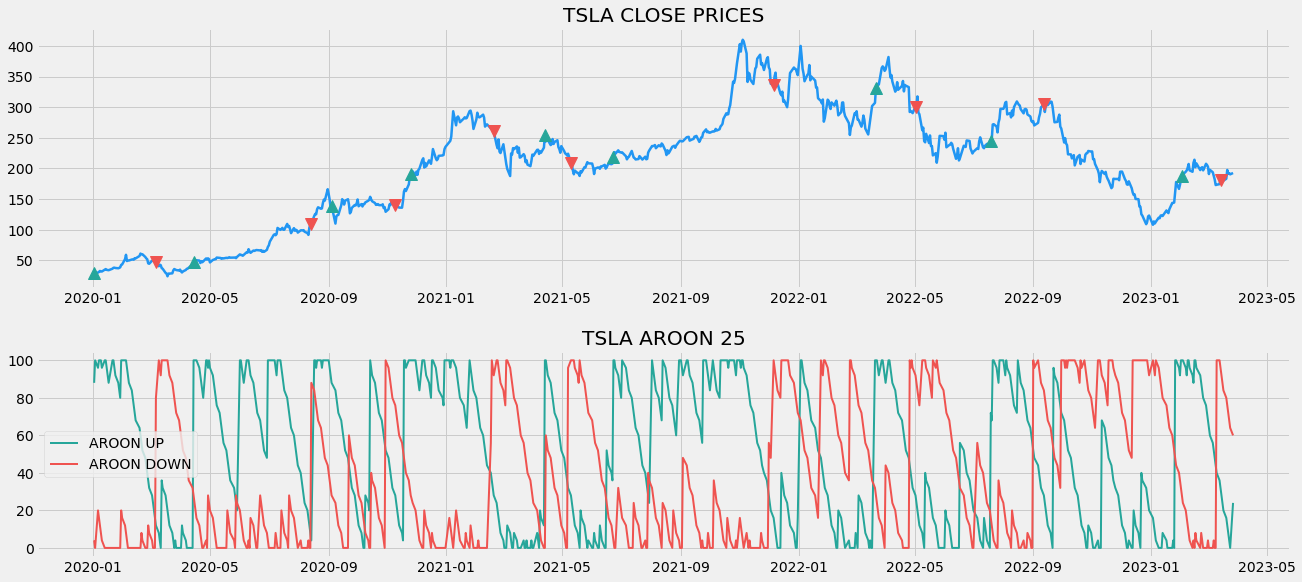

In [7]:
ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 4, colspan = 1)
ax1.plot(tsla['close'], linewidth = 2.5, color = '#2196f3')
ax1.plot(tsla.index, buy_price, marker = '^', color = '#26a69a', markersize = 12)
ax1.plot(tsla.index, sell_price, marker = 'v', color = '#ef5350', markersize = 12)
ax1.set_title('TSLA CLOSE PRICES')
ax2.plot(tsla['aroon_up'], color = '#26a69a', linewidth = 2, label = 'AROON UP')
ax2.plot(tsla['aroon_down'], color = '#ef5350', linewidth = 2, label = 'AROON DOWN')
ax2.legend()
ax2.set_title('TSLA AROON 25')
plt.show()

In [8]:
position = []
for i in range(len(aroon_signal)):
    if aroon_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(tsla['close'])):
    if aroon_signal[i] == 1:
        position[i] = 1
    elif aroon_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
aroon_up = tsla['aroon_up']
aroon_down = tsla['aroon_down']
close_price = tsla['close']
aroon_signal = pd.DataFrame(aroon_signal).rename(columns = {0:'aroon_signal'}).set_index(tsla.index)
position = pd.DataFrame(position).rename(columns = {0:'aroon_position'}).set_index(tsla.index)

frames = [close_price, aroon_up, aroon_down, aroon_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,close,aroon_up,aroon_down,aroon_signal,aroon_position
datetime,,,,,
2020-01-02,28.68000,88.0,4.0,1,1
2020-01-03,29.53000,100.0,0.0,0,1
2020-01-06,30.10000,96.0,20.0,0,1
2020-01-07,31.27000,100.0,16.0,0,1
2020-01-08,32.81000,100.0,12.0,0,1
...,...,...,...,...,...
2023-03-21,197.58000,12.0,76.0,0,0
2023-03-22,191.14999,8.0,72.0,0,0
2023-03-23,192.22000,4.0,68.0,0,0


In [9]:
tsla_ret = pd.DataFrame(np.diff(tsla['close'])).rename(columns = {0:'returns'})
aroon_strategy_ret = []

for i in range(len(tsla_ret)):
    returns = tsla_ret['returns'][i]*strategy['aroon_position'][i]
    aroon_strategy_ret.append(returns)
    
aroon_strategy_ret_df = pd.DataFrame(aroon_strategy_ret).rename(columns = {0:'aroon_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/tsla['close'][-1])
aroon_investment_ret = []

for i in range(len(aroon_strategy_ret_df['aroon_returns'])):
    returns = number_of_stocks*aroon_strategy_ret_df['aroon_returns'][i]
    aroon_investment_ret.append(returns)

aroon_investment_ret_df = pd.DataFrame(aroon_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(aroon_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the Aroon strategy by investing $100k in TSLA : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the Aroon strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the Aroon strategy by investing $100k in TSLA : 127048.16
Profit percentage of the Aroon strategy : 127%


In [10]:
def get_benchmark(start_date, investment_value):
    spy = get_historical_data('SPY', start_date)['close']
    benchmark = pd.DataFrame(np.diff(spy)).rename(columns = {0:'benchmark_returns'})
    
    investment_value = investment_value
    number_of_stocks = floor(investment_value/spy[-1])
    benchmark_investment_ret = []
    
    for i in range(len(benchmark['benchmark_returns'])):
        returns = number_of_stocks*benchmark['benchmark_returns'][i]
        benchmark_investment_ret.append(returns)

    benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(columns = {0:'investment_returns'})
    return benchmark_investment_ret_df

benchmark = get_benchmark('2020-01-01', 100000)

investment_value = 100000
total_benchmark_investment_ret = round(sum(benchmark['investment_returns']), 2)
benchmark_profit_percentage = floor((total_benchmark_investment_ret/investment_value)*100)
print(cl('Benchmark profit by investing $100k : {}'.format(total_benchmark_investment_ret), attrs = ['bold']))
print(cl('Benchmark Profit percentage : {}%'.format(benchmark_profit_percentage), attrs = ['bold']))
print(cl('Aroon Strategy profit is {}% higher than the Benchmark Profit'.format(profit_percentage - benchmark_profit_percentage), attrs = ['bold']))

Benchmark profit by investing $100k : 17977.68
Benchmark Profit percentage : 17%
Aroon Strategy profit is 110% higher than the Benchmark Profit
